In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [18]:
games = pd.read_csv('team_data_v4.csv')
games = games[['home_corsi_prop', 'away_corsi_prop', 'home_hits_prop', 'away_hits_prop', 'game_end']]
X = games.iloc[:, :4]
y = games.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

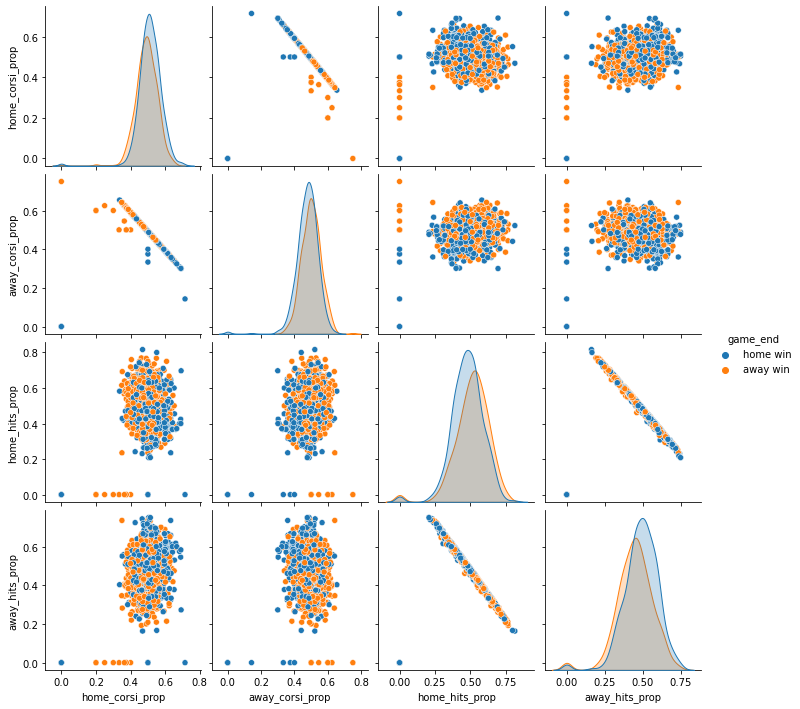

In [12]:
pairs = games.iloc[:, 3:]
pairs = pairs[['home_corsi_prop', 'away_corsi_prop', 'home_hits_prop', 'away_hits_prop', 'game_end']]
sns.pairplot(pairs, hue='game_end')

In [19]:
# K-means model construction

def pick_initial_centroids(df, k):
    return df.sample(k)

def update_centroids(features, centroids):
    dist = cdist(features, centroids)
    closest =  np.argmin(dist, axis=1)
    df = features.copy()
    df['cluster'] = closest
    return df.groupby('cluster').mean()


def kmeans(features, k):
    centroids = pick_initial_centroids(features, k)
    new_centroids = update_centroids(features, centroids)
    
    while not new_centroids.equals(centroids):
        centroids = new_centroids.copy()
        new_centroids = update_centroids(features, centroids)
        
    dist = cdist(features, centroids)
    closest =  np.argmin(dist, axis=1)
    df = features.copy()
    df['cluster'] = closest
    return df, centroids

In [23]:
def wcss(clustered):
    # Step 1 - find the centroids
    centroids = clustered.groupby('cluster').mean()
    # Step 2 - compute distances to each centroid, but extract, the distance for the assigned cluster
    wcss = cdist(clustered.iloc[:, :4], centroids)[np.arange(len(clustered)), clustered.iloc[:,-1]].sum()
    return wcss

41.50331079721731

Text(0.5, 0, 'K')

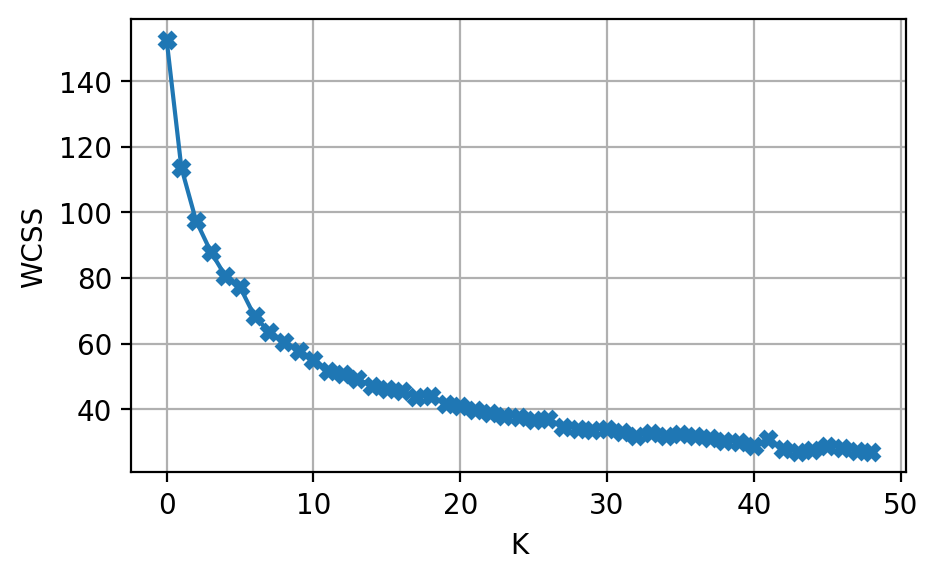

In [30]:
wcss_scores = [wcss(kmeans(X_train, k)[0]) for k in range(1, 50)]

plt.figure(figsize=(5,3), dpi=200)
plt.plot(wcss_scores, marker='X')
plt.grid()
plt.ylabel('WCSS')
plt.xlabel('K')

In [26]:
def classify_cluster(df, k):
    home = len(df[(df['cluster'] == k) & (df['game_end'] == 'home win')])
    away = len(df[(df['cluster'] == k) & (df['game_end'] == 'away win')])
    if home > away:
        return 'home win'
    else:
        return 'away win'

In [32]:
# Metrics for model

def predict(model, y_train, data):
    clustered, centroids = model
    clustered = clustered.join(y_train)
    dist = cdist(data, centroids)
    closest = np.argmin(dist, axis=1)
    df = data.copy()
    df['cluster'] = closest
    df['prediction'] = df.apply(lambda x: classify_cluster(clustered, x['cluster']), axis=1)
    return df['prediction']

def metrics(y, ypred):
    unique_classes = set(y) | set(ypred)
    n_classes = len(unique_classes)
    matrix = np.zeros(shape=(n_classes, n_classes), dtype=int)
    actual_prediction = list(zip(y, ypred))
    correct = 0
    for i,j in actual_prediction:
        if i == j:
            correct += 1
    return correct / len(actual_prediction)

def cross_validation(data, k):
    folds = 10
    accuracies = {}
    for f in range(folds):
        train_fold = data[data.index % folds != f]
        valid_fold = data[data.index % folds == f]
        X_train = train_fold.iloc[:, :-1]
        y_train = train_fold.iloc[:, -1]
        X_valid = valid_fold.iloc[:, :-1]
        y_valid = valid_fold.iloc[:, -1]
        cross_model = kmeans(X_train, k)
        accuracies[f] = metrics(y_valid, predict(cross_model, y_train, X_valid))
    return sum(accuracies.values()) / folds


Text(0.5, 0, 'K')

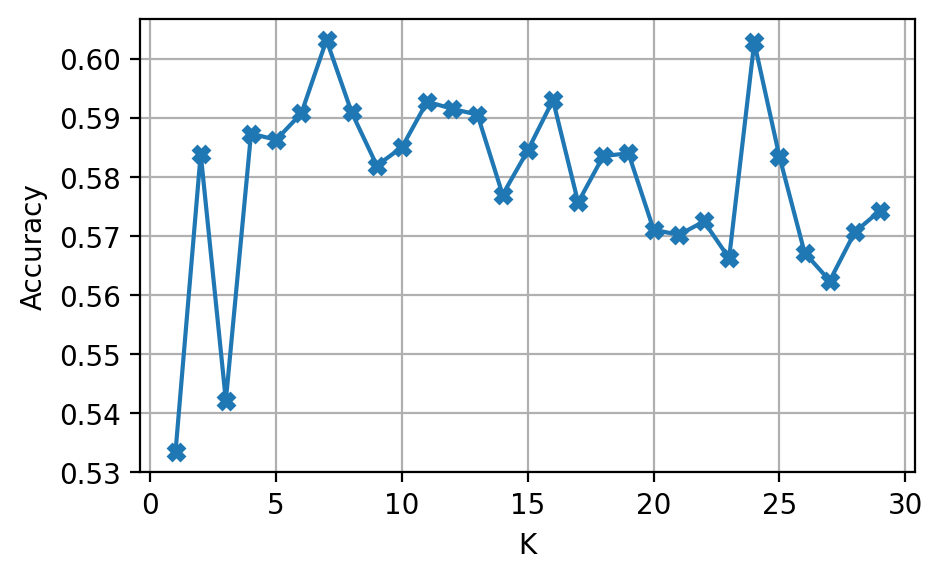

In [43]:
# Hyperparameter tuning
accuracies = [cross_validation(X_train.join(y_train), k) for k in range(1, 30)]

plt.figure(figsize=(5,3), dpi=200)
plt.plot(list(range(1, 30)), accuracies, marker='X')
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('K')

In [75]:
testing_acc = metrics(y_test, predict(kmeans(X_train, 24), y_train, X_test))
testing_acc

0.6227544910179641